## Exoplanet Model Installation + Tutorial

In [8]:
# install 
!pip install -U "exoplanet[extras]"

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: exoplanet[extras] in ./.local/lib/python3.7/site-packages (0.5.1)


In [3]:
# tests
!pip install -e ".[test]"

Defaulting to user installation because normal site-packages is not writeable
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /mnt_home/azuckerman


### Fitting artificial data

In [5]:
# import exoplanet
import exoplanet as xo

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


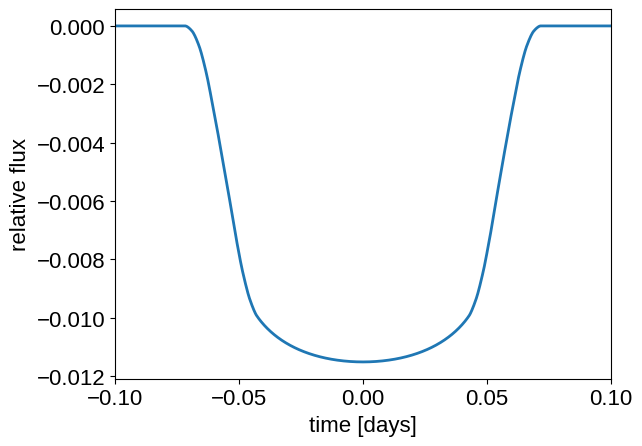

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [8]:
# construct a simple transit model
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

array([15.44703778,  9.29209002])

In [9]:
import pymc3 as pm
import pymc3_ext as pmx

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807484 -> 24793.539425611198


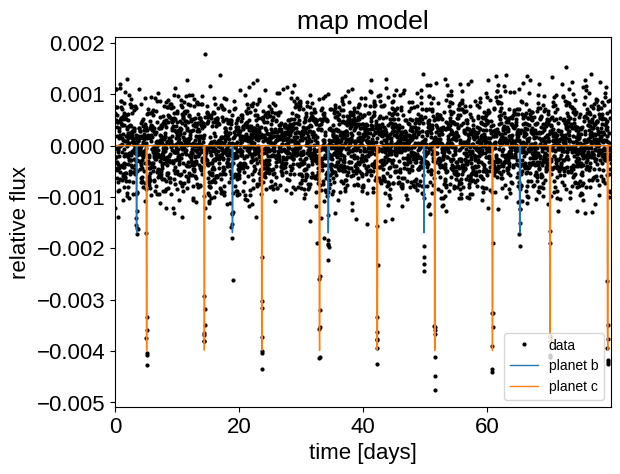

In [10]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

### Fitting TESS data (long version tutorial)

In [11]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


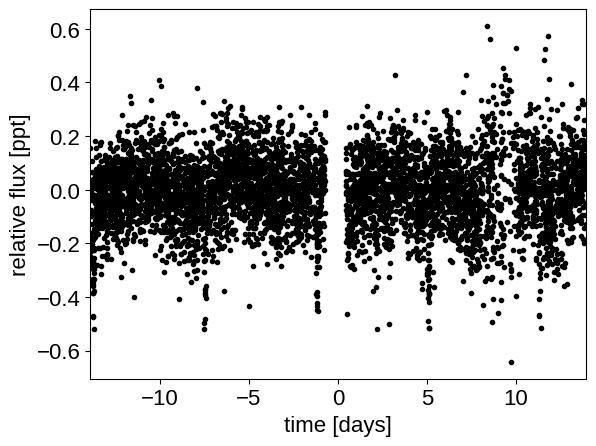

In [12]:
# download lightkurve

import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits

lc_file = lk.search_lightcurve(
    "TIC 261136679", sector=1, author="SPOC"
).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lc_file.remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

# For the purposes of this example, we'll discard some of the data
m = (lc.quality == 0) & (
    np.random.default_rng(261136679).uniform(size=len(time)) < 0.3
)

with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux[m] - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

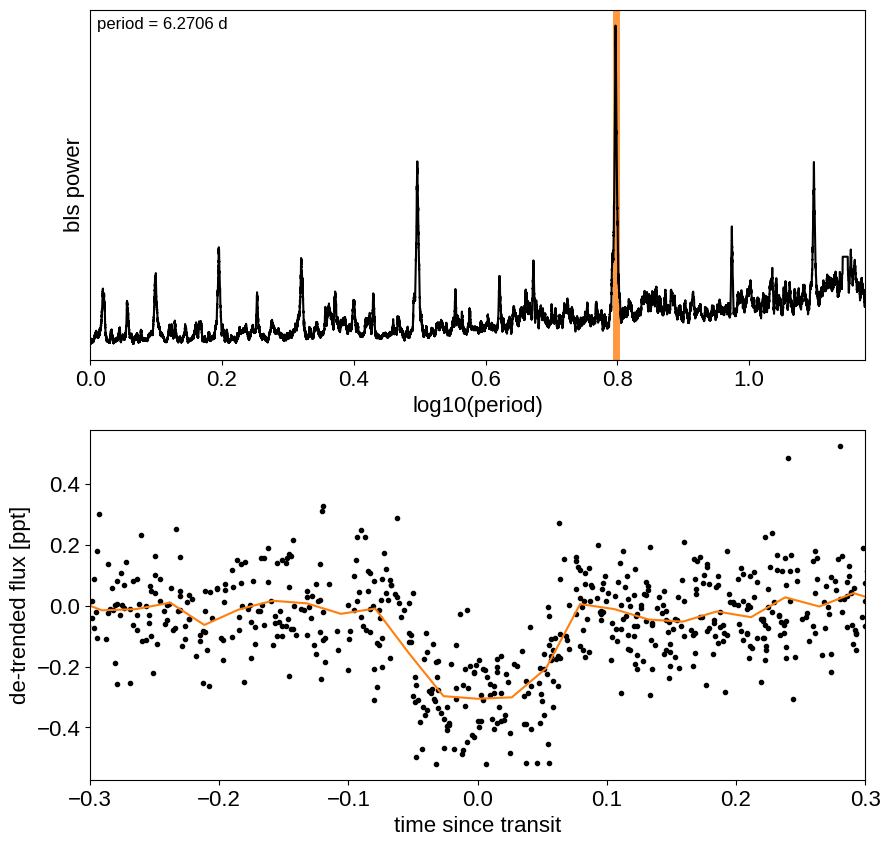

In [13]:
# use Astropy's box least squares to estimate the period, phase, and depth of the transit

from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

### Model transit in pyMC3

In [14]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_huang[0], sd=M_star_huang[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_huang[0], sd=R_star_huang[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 3338.1817955372744 -> 3460.398341134721
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3460.398341134721 -> 3465.9617441726537
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 3465.9617441726537 -> 3501.441788742472
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 3501.441788742472 -> 3507.3259047021447
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 3507.3259047021443 -> 3510.723293093732
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3510.723293093732 -> 3514.131734481666
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 3514.131734481666 -> 3515.1377310495564
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 3515.1377310495564 -> 3515.6567965760723
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 3515.6567965760723 -> 3515.676624506985
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 3515.676624506985 -> 3516.2740955316563
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3516.2740955316563 -> 3722.200730721466


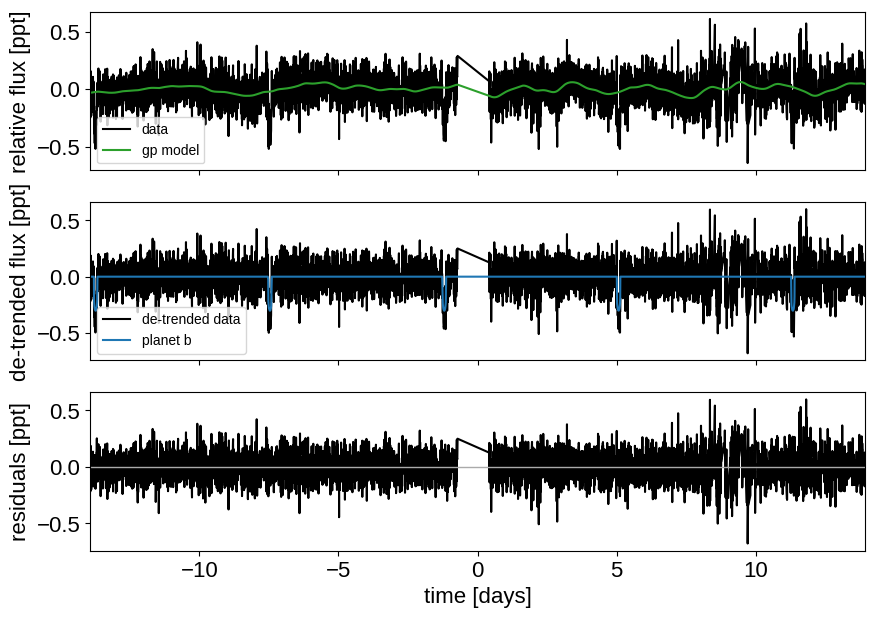

In [15]:
# plot the initial model
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 3879.897528109455 -> 3886.071717506431
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3886.071717506431 -> 3886.073633515106
optimizing logp for variables: [b]


message: Desired error not necessarily achieved due to precision loss.
logp: 3886.073633515106 -> 3886.0741001417964
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 3886.074100141798 -> 3886.0741689867305
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 3886.0741689867273 -> 3886.074320810492
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3886.074320810492 -> 3886.074323020232
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 3886.074323020232 -> 3886.0743421824977
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 3886.0743421824977 -> 3886.074342669352
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 3886.074342669352 -> 3886.0765813090543
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 3886.0765813090543 -> 3886.076590732288
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3886.07659073229 -> 3886.076893026044


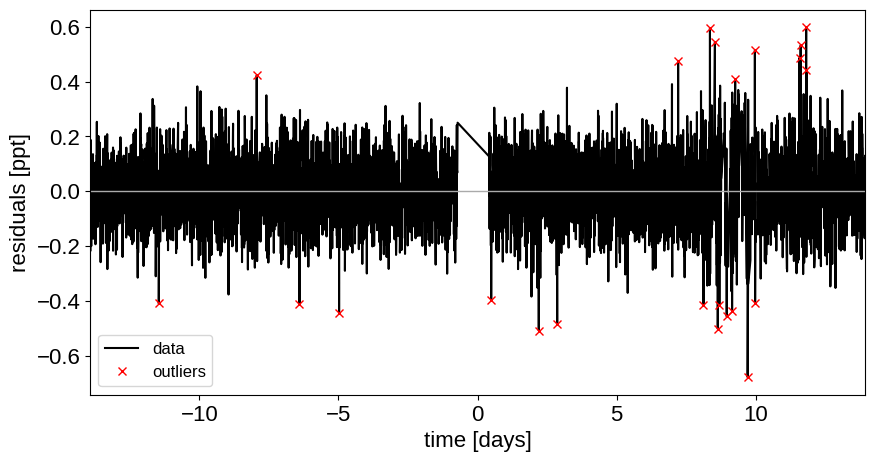

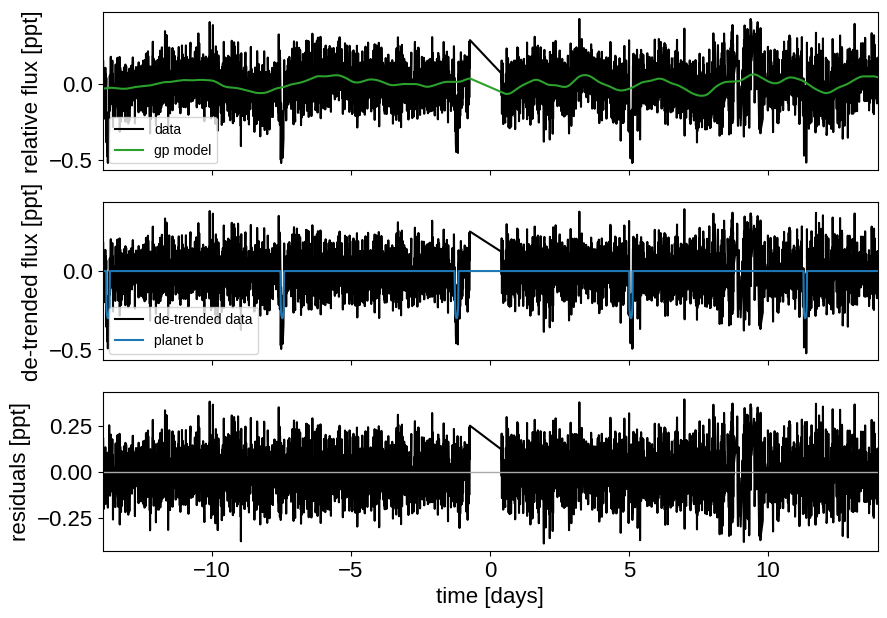

In [16]:
# sigma clip to remove outliers and rebuild model
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

In [17]:
# sample the model
import platform

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 1524 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.309,1.835,-3.028,2.935,0.069,0.049,799.0,1527.0,1.0
ecc,0.215,0.147,0.001,0.482,0.006,0.005,721.0,911.0,1.0
r_pl,0.018,0.001,0.017,0.020,0.000,0.000,716.0,922.0,1.0
b,0.485,0.216,0.073,0.829,0.011,0.008,406.0,477.0,1.0
t0,-13.735,0.002,-13.739,-13.730,0.000,0.000,1171.0,856.0,1.0
period,6.269,0.001,6.267,6.270,0.000,0.000,1314.0,1127.0,1.0
r_star,1.100,0.023,1.056,1.142,0.001,0.000,1741.0,1534.0,1.0
m_star,1.096,0.039,1.024,1.170,0.001,0.001,1657.0,1265.0,1.0
u_star[0],0.310,0.238,0.000,0.731,0.006,0.004,1437.0,809.0,1.0
u_star[1],0.222,0.319,-0.354,0.805,0.010,0.007,1101.0,1029.0,1.0


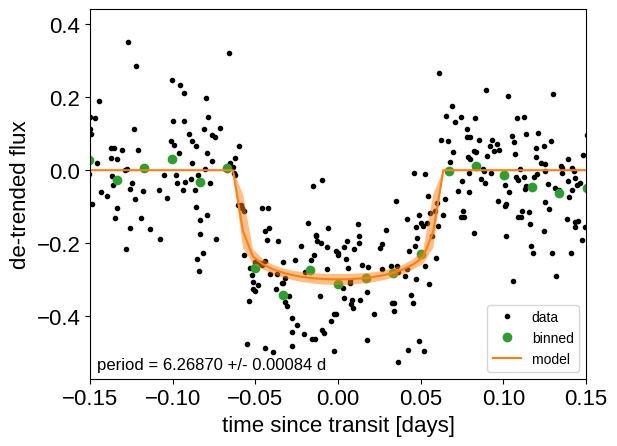

In [19]:
# plot results
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [20]:
# make corner plots

import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)

TypeError: cannot perform reduce with flexible type

### Fitting TESS data (short version tutorial)

In [11]:
import exoplanet as xo
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.1'


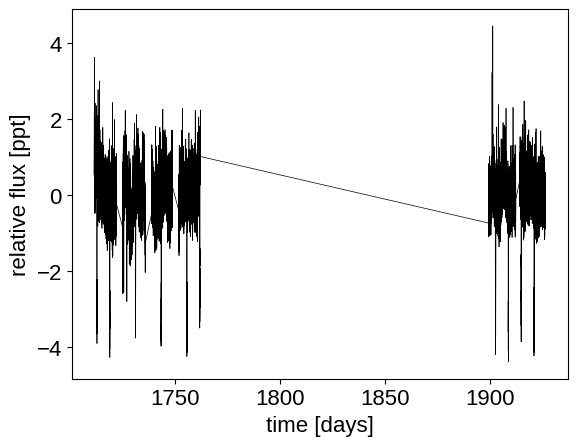

In [12]:
# download lightcurve

lcfs = lk.search_lightcurve(
    "TIC 286923464", mission="TESS", author="SPOC"
).download_all(flux_column="pdcsap_flux")
lc = lcfs.stitch().remove_nans().remove_outliers(sigma=7)

x = np.ascontiguousarray(lc.time.value, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
_ = plt.ylabel("relative flux [ppt]")

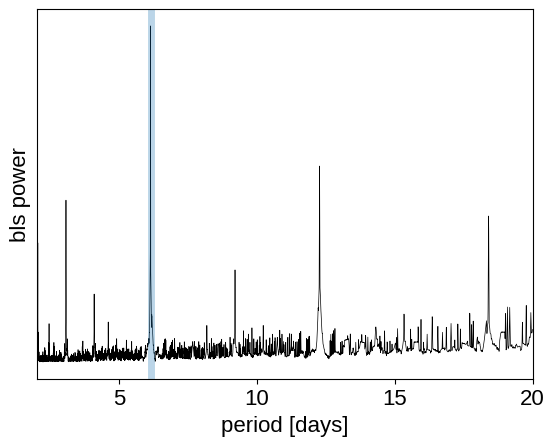

In [13]:
# get the 'guess' parameters from a bls model -- I will do this using the known parameters (?)

import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
_ = plt.xlim(pg["bls"].period.min(), pg["bls"].period.max())

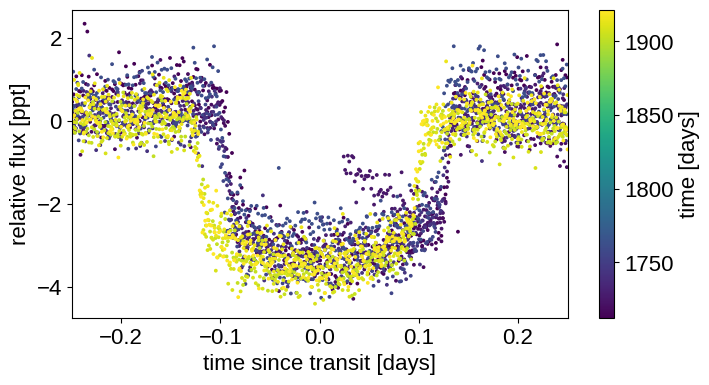

In [14]:
# Fold lightcurve and only examine region around transit

transit_mask = (
    np.abs(
        (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

In [29]:
# set up PyMC model

import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess


with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0) # ADZ: mean of normal dist
    u = xo.QuadLimbDark("u") # ADZ: limb darkening parameter
    star_params = [mean, u] 

    # Gaussian process noise model     ADZ: -- I think these are liklihood distributions for these parameters
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr)) # ADZ: standard deviation
    log_sigma_gp = pm.Normal("log_sigma_gp", mu=0.0, sigma=10.0)
    log_rho_gp = pm.Normal("log_rho_gp", mu=np.log(10.0), sigma=10.0)
    kernel = terms.SHOTerm(
        sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
    )
    noise_params = [sigma, log_sigma_gp, log_rho_gp]

    # Planet parameters
    log_ror = pm.Normal(
        "log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0
    )
    ror = pm.Deterministic("ror", tt.exp(log_ror)) # ADZ: Seems that 'deterministic' means we define this as a known given log_ror distribution

    # Orbital parameters # ADZ: I think create prob distribution for parameters from guessed values?
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    dur = pm.Deterministic("dur", tt.exp(log_dur))
    b = xo.distributions.ImpactParameter("b", ror=ror)

    # Set up the orbit -- ADZ: should I just use the knowns? With added in probabilty distributions?
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
    )

    # Finally the GP observation model
    gp = GaussianProcess(kernel, t=x, diag=yerr ** 2 + sigma ** 2) # ADZ: GP is a way of predicting new data based on known data by interpolating 
    gp.marginal("obs", observed=y - lc_model)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [sigma])
    map_soln = pmx.optimize(map_soln, [ror, b, dur])
    map_soln = pmx.optimize(map_soln, noise_params)
    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

NameError: name 'yerr' is not defined

## Fitting Kepler-69b

In [35]:
import exoplanet as xo
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.optimize import curve_fit
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.5.1'


Text(0, 0.5, 'relative flux [ppt]')

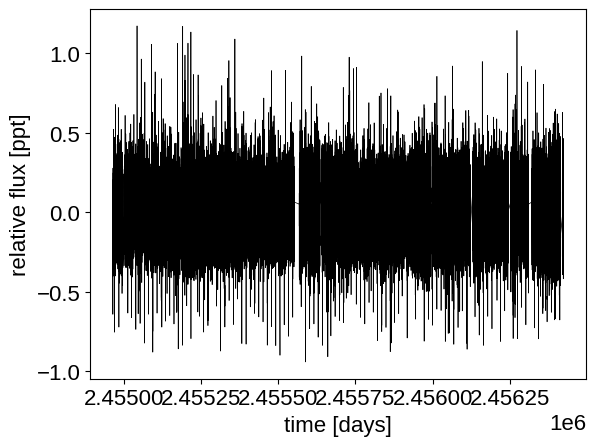

In [36]:
# download lightcurve

obs_type = 'kepler'
planet_name = 'kepler-69 b'
star_name = 'kepler-69'
#search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
#lc_collection = search_result.download_all().stitch().flatten(window_length=901).remove_outliers()

lcfs = lk.search_lightcurve(star_name, mission=obs_type, cadence = 'long').download_all()
lc = lcfs.stitch().remove_nans().flatten().remove_outliers(sigma=7)

time = np.ascontiguousarray(lc.time.value, dtype=np.float64) + 2454833
flux = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
flux_err = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(time))

plt.plot(time, flux, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")

In [37]:
# get 'guess'/known properties from NASA exoplanet archive rather than a bls model as above

planet = NasaExoplanetArchive.query_object(planet_name)
period_guess = np.nanmedian(planet['pl_orbper']).value # Planet period [Days]
t0_guess = np.nanmedian(planet['pl_tranmid']).value # Transit midpoint (??) [Days]
R_p = np.nanmedian(planet['pl_rade']).value * 0.0091577 # Planet radius [Ro]
R_star = np.nanmedian(planet['st_rad']).value  # Star radius [Ro]
impact_parameter = np.nanmedian(planet['pl_imppar']) # impact parameter 
duration = np.nanmedian(planet['pl_trandur']).value # Planet transit duration [Days]
RpRs_guess = R_p/R_star # Planet star radius ratio = sqrt(transit depth)
depth_guess = RpRs_guess**2
num_transits = int(np.floor((time[-1] - t0_guess) / period_guess))

# get cadence information
cadence_type = lc.meta['OBSMODE'] 
if obs_type == 'Kepler' or obs_type == 'kepler':
    if cadence_type == 'long cadence':
        cadence = 1764 # sec
    if cadence_type == 'short cadence':
        cadence = 58.85 # sec          
if obs_type == 'TESS':
    print('TESS CADENCE INFO NOT YET IMPLEMENTED!')
    

print('period: ' + str(np.round(period_guess,3)))
print('duration: ' + str(np.round(duration,3)))
print('t0: ' + str(np.round(t0_guess,3)))
print('RpRs: ' + str(np.round(RpRs_guess,3)))
print('Depth: ' + str(np.round(depth_guess,3)))
print('impact parameter: ' + str(np.round(impact_parameter,3)))

period: 13.722
duration: 5.155
t0: 2454970.841
RpRs: 0.022
Depth: 0.0
impact parameter: 0.254


Modelling transit 0
mean                -3.22
u_quadlimbdark__    -2.77
sigma_log__         -0.53
log_sigma_gp        -3.22
log_rho_gp          -3.22
log_ror             -3.22
log_period          -0.92
t0                  -0.92
log_dur             -3.22
b_impact__          -1.39
obs                 24.25
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]


message: Optimization terminated successfully.
logp: 1.607655288962821 -> 4.8247483699998135


optimizing logp for variables: [log_dur, b, log_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: 4.8247483699998135 -> 17.590610252290503
optimizing logp for variables: [log_rho_gp, log_sigma_gp, sigma]


message: Optimization terminated successfully.
logp: 17.590610252290503 -> 28.556068127538115
optimizing logp for variables: [u, mean]


message: Optimization terminated successfully.
logp: 28.556068127538115 -> 30.89196216264879
optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_rho_gp, log_sigma_gp, sigma, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 30.89196216264879 -> 42.61884302578887


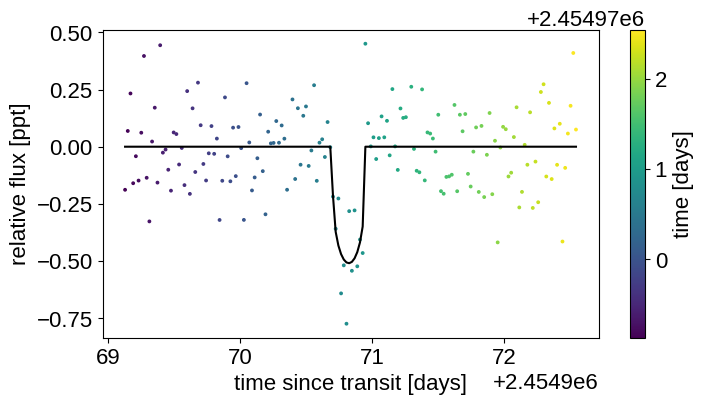

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, log_dur, t0, log_period, log_ror, log_rho_gp, log_sigma_gp, sigma, u, mean]


RuntimeError: Chain 1 failed.

In [34]:
# fit transits -- skip the folding to fit individual transits
for transit_idx in [0]:#np.linspace(num_transits-1,num_transits):
    
    fit_window_size = 0.125    # Fraction of period on both sides of the expected transit midpoints to fit for transit
    inner_window_size = 0.125*0.5 # Fraction of period on both sides of expected midpoint to check for missing data
    expected_points_per_inner_window = np.floor((period_guess * 24 * 60 * 60 * inner_window_size*2) / cadence)

    #def fit_exoplanet(transit_idx, verbosity):
    #transit_idx = 10 
    verbosity = 0

    # area around expected transit
    low_bound = t0_guess + period_guess * transit_idx - period_guess * fit_window_size    
    up_bound = t0_guess + period_guess * transit_idx + period_guess * fit_window_size
    # all intervals are ~same in time duration, but not in number of steps/pixels
    interval = (low_bound < time)*(time < up_bound)
    time_interval = np.max(time[time < up_bound]) -  np.min(time[time > low_bound])
    length = len(time[interval])

    # for checking that datapoints immediatley around transit is not missing
    # becuase the location of the missing data within the transit window mattters
    inner_low_bound = t0_guess + period_guess * transit_idx - period_guess * inner_window_size    
    inner_up_bound = t0_guess + period_guess * transit_idx + period_guess * inner_window_size
    # all intervals are ~same in time duration, but not in number of steps/pixels
    inner_interval = (inner_low_bound < time)*(time < inner_up_bound)
    inner_time_interval = np.max(time[time < inner_up_bound]) -  np.min(time[time > inner_low_bound])
    inner_length = len(time[inner_interval])

    apply_thresholds = 0
    min_points_threshold = expected_points_per_inner_window * 0.90
    if apply_thresholds:
        if (inner_length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
     #       return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan

    apply_thresholds = 1
    min_points_threshold = expected_points_per_inner_window * 0.90
    if apply_thresholds:
        if (inner_length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')  
            continue 
    
    print('Modelling transit ' + str(transit_idx))

    with pm.Model() as model:

        # Stellar parameters
        mean = pm.Normal("mean", mu=0.0, sigma=10.0) # ADZ: mean of normal dist
        u = xo.QuadLimbDark("u") # ADZ: limb darkening parameter
        star_params = [mean, u] 

        # Gaussian process noise model     ADZ: -- I think these are liklihood distributions for these parameters
        sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(flux_err[interval])) # ADZ: standard deviation
        log_sigma_gp = pm.Normal("log_sigma_gp", mu=0.0, sigma=10.0)
        log_rho_gp = pm.Normal("log_rho_gp", mu=np.log(10.0), sigma=10.0)
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp), rho=tt.exp(log_rho_gp), Q=1.0 / 3
        )
        noise_params = [sigma, log_sigma_gp, log_rho_gp]

        # Planet parameters # ADZ: ror == radius ratio corresponding to transit depth and impact parameter b
        log_ror = pm.Normal(
            "log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0
        )
        ror = pm.Deterministic("ror", tt.exp(log_ror)) # ADZ: Seems that 'deterministic' means we define this as a known given log_ror distribution

        # Orbital parameters # ADZ: I think create prob distribution for parameters from guessed values?
        log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0) # ADZ: what if I just make sigma 0?
        period = pm.Deterministic("period", tt.exp(log_period)) # I think this means it picks a specific value from the distribution
        t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
        log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0) # ADZ: what if I just make sigma 0?
        dur = pm.Deterministic("dur", tt.exp(log_dur))
        b = xo.distributions.ImpactParameter("b", ror=ror)

        # Set up the orbit -- ADZ: should I just use the knowns? With added in probabilty distributions?
        orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

        # We're going to track the implied density for reasons that will become clear later
        pm.Deterministic("rho_circ", orbit.rho_star)

        # Set up the mean transit model
        star = xo.LimbDarkLightCurve(u)
        lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit=orbit, r=ror, t=time[interval]), axis=-1)


        # Finally the GP observation model
        gp = GaussianProcess(kernel, t=time[interval], diag=flux_err[interval] ** 2 + sigma ** 2) # ADZ: GP is a way of predicting new data based on known data by interpolating 
        gp.marginal("obs", observed=flux[interval] - lc_model)

        # what do the lines below this do??

        # Double check that everything looks good - we shouldn't see any NaNs!
        print(model.check_test_point()) # checks probability of a point in parameter space (?)

        # Optimize the model
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, [sigma])
        map_soln = pmx.optimize(map_soln, [ror, b, dur])
        map_soln = pmx.optimize(map_soln, noise_params)
        map_soln = pmx.optimize(map_soln, star_params)
        map_soln = pmx.optimize(map_soln)

        plot_fit =1
        if plot_fit == 1:
            with model:
                lc_pred = pmx.eval_in_model(lc_model, map_soln)
                gp_pred = pmx.eval_in_model(gp.predict(flux[interval] - lc_pred), map_soln)

            plt.figure(figsize=(8, 4))
            #time_fold = (time[interval] - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
               # "period"] - 0.5 * map_soln["period"] # ADZ: FOLDING SHOULDN'T BE NECCESSARY THOOGH...
            inds = np.argsort(time[interval])
            plt.scatter(time[interval], flux[interval] - gp_pred - map_soln["mean"], c=time[interval], s=3)
            plt.plot(time[interval][inds], lc_pred[inds] - map_soln["mean"], "k")
            plt.xlabel("time since transit [days]")
            plt.ylabel("relative flux [ppt]")
            plt.colorbar(label="time [days]")
            plt.show()
           # _ = plt.xlim(-0.25, 0.25)


        # sampling

        np.random.seed(286923464)
        
        with model:
            trace = pmx.sample(
                tune=1000,
                draws=1000,
                start=map_soln,
                chains=2,
                cores=2,
                return_inferencedata=True, 
            )

        # summary stats
        import arviz as az

        az.summary(trace) 
        
    #return fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip



In [4]:
print(pm.Model().check_test_point())

Series([], Name: Log-probability of test_point, dtype: float64)


### TESTING

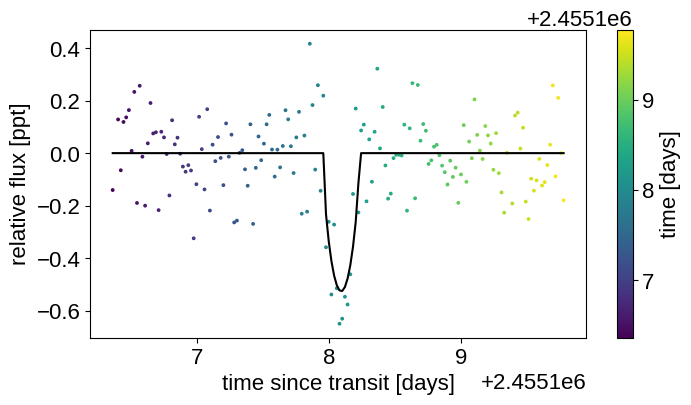

In [60]:
with model:
    lc_pred = pmx.eval_in_model(lc_model, map_soln)
    gp_pred = pmx.eval_in_model(gp.predict(flux[interval] - lc_pred), map_soln)

plt.figure(figsize=(8, 4))
#time_fold = (time[interval] - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
   # "period"] - 0.5 * map_soln["period"] # ADZ: FOLDING SHOULDN'T BE NECCESSARY THOOGH...
inds = np.argsort(time[interval])
plt.scatter(time[interval], flux[interval] - gp_pred - map_soln["mean"], c=time[interval], s=3)
plt.plot(time[interval][inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
# _ = plt.xlim(-0.25, 0.25)